In [ ]:
import io
import os

import numpy as np
import pandas as pd

# teradata lib
from teradataml import *

# LLM
import sqlalchemy
from sqlalchemy import create_engine
from langchain import PromptTemplate, SQLDatabase, LLMChain
from langchain_community.utilities.sql_database import SQLDatabase
from langchain_community.agent_toolkits import create_sql_agent
from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage
from langchain_core.prompts.chat import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    MessagesPlaceholder,
)

configure.byom_install_location = 'mldb'
configure.val_install_location = 'val'

# Suppress warnings
warnings.filterwarnings("ignore")
display.max_rows = 5

<hr style="height:2px;border:none;background-color:#00233C;">
<b style = 'font-size:20px;font-family:Arial;color:#00233C'>2. Connect to Vantage</b>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>We will be prompted to provide the password. We will enter the password, press the Enter key, and then use the down arrow to go to the next cell.</p>

In [ ]:
%run -i ../startup.ipynb
eng = create_context(host = 'host.docker.internal', username='demo_user', password = password)
print(eng)

In [ ]:
%%capture
execute_sql("SET query_band='DEMO=Support_Agents.ipynb;' UPDATE FOR SESSION;")

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>We begin running steps with Shift + Enter keys. </p>

<hr style="height:2px;border:none;background-color:#00233C;">
<b style = 'font-size:20px;font-family:Arial;color:#00233C'>3. Load Customer360 data into Vantage</b>

In [ ]:
df = pd.read_csv('./data/customer360.csv')

In [ ]:
copy_to_sql(df, 'customer360', if_exists='replace')

In [ ]:
cust_tdf = DataFrame('customer360')

In [ ]:
cust_tdf.head(2)

<hr style="height:2px;border:none;background-color:#00233C;">
<b style = 'font-size:20px;font-family:Arial;color:#00233C'>4. Load trained PMML Model into Vantage</b>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>We pass the local PMML file to the save_byom function. This function loads the <b>mm_fraud_glm_model.pmml</b> file into Vantage in a table called <b>mm_glm</b>. If there is already a model with the same name, we will delete the previous one, and a new one will be loaded.</p>

In [ ]:
# Load the PMML file into Vantage
try:
    res = save_byom(model_id = 'mm_glm1', model_file = 'propensity_model_regressor.pmml', table_name = 'mm_glm')

except Exception as e:
    # if our model exists, delete and rewrite
    if str(e.args).find('TDML_2200') >= 1:
        res = delete_byom(model_id = 'mm_glm1', table_name = 'mm_glm')
        res = save_byom(model_id = 'mm_glm1', model_file = 'propensity_model_regressor.pmml', table_name = 'mm_glm')
        pass
    else:
        raise

In [ ]:
DataFrame('mm_glm')

<hr style="height:2px;border:none;background-color:#00233C;">
<b style = 'font-size:20px;font-family:Arial;color:#00233C'>5. Score the model directly in Vantage</b>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>We will use PMMLPredict to score the model on data residing in Vantage without moving data.</p>

In [ ]:
example_input_data = pd.DataFrame(
    [
        {
            "Customer ID": "C1001",
            "Age": 53,
            "Gender": "Male",
            "Income Level": 50000,
            "Occupation": "Engineer",
            "Education Level": "Bachelor",
            "Travel Frequency": 2,
            "Destination": "Domestic",
            "Trip Duration": 7,
            "Travel Purpose": "Leisure",
            "Previous Dental Treatment": True,
            "General Health Status": "Poor",
            "Dental Issue History": True,
            "Dental Visit Frequency": 10,
            "Previous Insurance Policy": True,
            "Claims History": 1,
            "Insurance Duration": 5,
            "Online Behavior": "High",
            "Marketing Engagement": "High",
            "Social Media Activity": "Medium",
            "Credit Score": 700,
            "Spending Pattern": "Medium",
            "Payment History": "Good",
        }
    ]
)

In [ ]:
copy_to_sql(example_input_data, 'df_test', if_exists='replace')

In [ ]:
df_test = DataFrame('df_test')

In [ ]:
model_tdf = retrieve_byom("mm_glm1", table_name = 'mm_glm')

# Run the PMMLPredict function in Vantage
result = PMMLPredict(
            modeldata = model_tdf,
            newdata = df_test,
            accumulate = ['Customer ID'],
            overwrite_cached_models = '*',
            )

In [ ]:
print(result.show_query())

In [ ]:
result.result

-----------------------------------------

## Install libs

In [ ]:
%%capture --no-stderr
%pip install -U --quiet langchain-community tiktoken langchain-openai langchainhub faiss-cpu langchain langgraph langchain-text-splitters

In [ ]:
import getpass
import os

def _set_env(key: str):
    if key not in os.environ:
        os.environ[key] = getpass.getpass(f"{key}:")

_set_env("OPENAI_API_KEY")

### setup lookup

In [ ]:
import re

import numpy as np
import openai
from langchain_core.tools import tool
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import FAISS

from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import FAISS

# loader = PyPDFLoader(
#     "./data/travel-insurance-policy.pdf",
# )
# # docs = [WebBaseLoader(url).load() for url in urls]
# docs_list = loader.load()

# text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
#     chunk_size=1000, chunk_overlap=200
# )
# doc_splits = text_splitter.split_documents(docs_list)

# embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# # Add to vectorDB
# vector_store = FAISS.from_documents(doc_splits, embeddings)

#     # Save the index for reuse
# vector_store.save_local("policy_index")

In [ ]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
retriever = FAISS.load_local("policy_index", embeddings, allow_dangerous_deserialization=True)

### Tool 2: Lookup

In [ ]:
@tool
def lookup_policy(query: str) -> str:
    """Consult the company insurance policies to check whether certain options are permitted."""
    docs = retriever.similarity_search(query, k=3)
    return "\n\n".join([doc.page_content for doc in docs])

In [ ]:
# lookup_policy("dental treatment")

### fetch user info

In [ ]:
# connection = eng.raw_connection()
# connection.cursor()

In [ ]:
# qry = "select * from customer360  WHERE CustomerID = ? "
# CustomerID= 'C1002'

# # with eng.raw_connection() as connection:
# conn = eng.raw_connection()
# cursor = conn.cursor()
# rows =cursor.execute(qry, (CustomerID,)).fetchall()
# column_names = [column[0] for column in cursor.description]
# results = [dict(zip(column_names, row)) for row in rows]
# cursor.close()
# conn.close()

### Tool 2: Insurance policy - DB query

In [ ]:
import sqlite3
from datetime import date, datetime
from typing import Optional

import pytz
from langchain_core.runnables import RunnableConfig

thought_history = []

def logs(msg: str):
    print(f"\nℹ️ LOGS : {msg}")
    print("=" * 50)

def think(thought: str):
    """Record agent's thinking process"""
    thought_history.append({"thought": thought, "timestamp": datetime.now().isoformat()})
    print(f"\n🤔 THINKING: {thought}")
    
def act(action: str, result: any):
    """Record agent's actions and results"""
    thought_history.append({
        "action": action,
        "result": result,
        "timestamp": datetime.now().isoformat()
    })
    print(f"🎯 ACTION: {action}")
    print(f"📝 RESULT: {result}\n")
    print("=" * 50)

@tool
def fetch_user_insurance_information(config: RunnableConfig) -> dict:
    """Fetch all the insurance policies for the user along with corresponding personal information and policy information.

    Returns:
        A dictionary which contains the user's personal and policy details, Claim details, etc. to the user.
    """
    logs("fetch_user_insurance_information called")
    configuration = config.get("configurable", {})
    customer_id = configuration.get("customer_id", None)
    if not customer_id:
        raise ValueError("No passenger ID configured.")


    qry = "select * from customer360  WHERE CustomerID = ? "

    # with eng.raw_connection() as connection:
    conn = eng.raw_connection()
    cursor = conn.cursor()
    rows = cursor.execute(qry, (customer_id,)).fetchall()
    column_names = [column[0] for column in cursor.description]
    results = [dict(zip(column_names, row)) for row in rows]
    cursor.close()
    conn.close()
    act("fetch_user_insurance_information", results[0])
    return results

In [ ]:
# qry = "select * from customer360  WHERE CustomerID = ? "

# # with eng.raw_connection() as connection:
# conn = eng.raw_connection()
# cursor = conn.cursor()
# rows = cursor.execute(qry, ('C1001',)).fetchall()
# column_names = [column[0] for column in cursor.description]
# results = [dict(zip(column_names, row)) for row in rows]

In [ ]:
# results[0]

### Tool 3: Generate the Insurance Proposal - DB Query

In [ ]:
@tool
def generate_insurance_proposal(config: RunnableConfig) -> dict:
    """Fetch all the insurance policies for the user along with corresponding personal information and policy information.

    Returns:
        Generate a Dental Treatment Proposal for given user.
    """
    logs("generate_insurance_proposal called")
    think("I have create a proposal for the Dental Treatment as addon to existing Insurance")
    
    configuration = config.get("configurable", {})
    customer_id = configuration.get("customer_id", None)
    if not customer_id:
        raise ValueError("No passenger ID configured.")
    # customer_id = 'C1001'

    qry = "select * from customer360  WHERE CustomerID = ? "

    # with eng.raw_connection() as connection:
    conn = eng.raw_connection()
    cursor = conn.cursor()
    rows = cursor.execute(qry, (customer_id,)).fetchall()
    column_names = [column[0] for column in cursor.description]
    results = [dict(zip(column_names, row)) for row in rows]
    cursor.close()
    conn.close()
    act("generate_insurance_proposal - Get user details", results[0])
    
    # setup LLM
    llm = ChatOpenAI(temperature=0, streaming=True, model="gpt-4o-mini")
    logs("Now, generating the Proposal")
    primary_assistant_prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful customer support assistant for ABC Overseas Travel Insurance. "
                "Use the provided customer information and write a dental treatment proposal, as addon to existing insurance policies,"
                "Write a travel insurance proposal for Dental Treatment as addon using given features. Write it with proper markdown and style."
                "\n\nCurrent user:\n<User>\n{user_info}\n</User>"
                "\nCurrent time: {time}.",
            ),
             ("placeholder", "{messages}"),
        ]
    ).partial(time=datetime.now)

    prompt1 = primary_assistant_prompt.format_messages(user_info=results[0])
    response = llm.invoke(prompt1)
    act("generate_insurance_proposal - generate the proposal", response.content)
    return response.content

In [ ]:
# generate_insurance_proposal(config)

In [ ]:
# llm = ChatOpenAI(temperature=0, streaming=True, model="gpt-4o-mini")

# primary_assistant_prompt = ChatPromptTemplate.from_messages(
#     [
#         (
#             "system",
#             "You are a helpful customer support assistant for ABC Overseas Travel Insurance. "
#             "Use the provided customer information and write a dental treatment proposal, as addon to existing insurance policies,"
#             "Write a travel insurance proposal for Dental Treatment as addon using given features. Write it with proper markdown and style."
#             "\n\nCurrent user:\n<User>\n Customer ID= C1001"
#             "\nCurrent time: {time}.",
#         ),
#          ("human", "{messages}"),
#     ]
# ).partial(time=datetime.now)

# prompt1 = primary_assistant_prompt.format_messages(messages="Mr. Bob")

# response = llm.invoke(prompt1)

In [ ]:
# print(response.content)

### Tool 4: Predict the user's Propensity - DB Query

In [ ]:
@tool
def fetch_user_propensity(config: RunnableConfig) -> dict:
    """Fetch propensity to buy a dental treatment based on customer's personal information and previous health and dental related information.

    Returns:
        A dictionary which contains the customer's Customer ID and prediction.
    """
    logs("fetch_user_propensity called")
    think("I have to pass customer's details to ClearScape Analytics hosted Model to get the propensity of buying the Dental Treatment")
    configuration = config.get("configurable", {})
    customer_id = configuration.get("customer_id", None)
    if not customer_id:
        raise ValueError("No passenger ID configured.")
        
    qry = """
    SELECT * FROM "mldb".PMMLPredict(
        ON "df_test" AS InputTable
        PARTITION BY ANY 
        ON (select model_id,model from "DEMO_USER"."mm_glm") AS ModelTable
        DIMENSION
        USING
        Accumulate('Customer ID')
        OverwriteCachedModel('*')
    ) as sqlmr
    """

    conn = eng.raw_connection()
    cursor = conn.cursor()
    rows = cursor.execute(qry).fetchall()
    column_names = [column[0] for column in cursor.description]
    results = [dict(zip(column_names, row)) for row in rows]
    cursor.close()
    conn.close()
    act("fetch_user_propensity", results[0])
    return results[0]

### Utilities

In [ ]:
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda

from langgraph.prebuilt import ToolNode


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

# Part 1: Zero-shot Agent

### State

In [ ]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

### Agent

In [ ]:
# from langchain_anthropic import ChatAnthropic
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            configuration = config.get("configurable", {})
            customer_id = configuration.get("customer_id", None)
            state = {**state, "user_info": customer_id}
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}

# setup LLM
llm = ChatOpenAI(temperature=0, streaming=True, model="gpt-4o-mini")

primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful customer support assistant for ABC Overseas Travel Insurance. "
            " Use the provided tools to search for customer information, insurance policies, and other information to assist the user's queries. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            "\n\nCurrent user:\n<User>\n{user_info}\n</User>"
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)

part_1_tools = [
    fetch_user_insurance_information,
    fetch_user_propensity,
    lookup_policy,
]
part_1_assistant_runnable = primary_assistant_prompt | llm.bind_tools(part_1_tools)

### Define Graph
Now, create the graph. The graph is the final assistant for this section.

In [ ]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)

# Define nodes: these do the work
builder.add_node("assistant", Assistant(part_1_assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(part_1_tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)

builder.add_edge("tools", "assistant")

# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.
memory = MemorySaver()
part_1_graph = builder.compile(checkpointer=memory)

In [ ]:
from IPython.display import Image, display

try:
    display(Image(part_1_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### Example Conversation

Now it's time to try out our mighty chatbot! Let's run it over the following list of dialog turns. If it hits a "RecursionLimit", that means the agent wasn't able to get an answer in the allocated number of steps. That's OK! We have more tricks up our sleeve in later sections of this tutorial.

In [ ]:
import shutil
import uuid

# Let's create an example conversation a user might have with the assistant
tutorial_questions = [
    # "Hi there, I am travelling to Malasiya, Does my insurance cover medical expense?",
    # "What is the Coverage Amount for my policy?"
    "What is the propnsity to buy dental treatment?"
]

thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The customer_id is used in our insurance policy tools to
        # fetch the user's insurance policy information
        "customer_id": "C1001",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}


_printed = set()
for question in tutorial_questions:
    events = part_1_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)

# Part-2

In [ ]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    user_info: str


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


# setup LLM
llm = ChatOpenAI(temperature=0, streaming=True, model="gpt-4o-mini")

assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful customer support assistant for ABC Overseas Travel Insurance. "
            " Use the provided tools to search for customer information, insurance policies, and other information to assist the user's queries. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            "\n\nCurrent user:\n<User>\n{user_info}\n</User>"
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)

part_2_tools = [
    fetch_user_insurance_information,
    fetch_user_propensity,
    generate_insurance_proposal,
    lookup_policy,
]

part_2_assistant_runnable = assistant_prompt | llm.bind_tools(part_2_tools)

In [ ]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)


def user_info(state: State):
    return {"user_info": fetch_user_insurance_information.invoke({})}


# NEW: The fetch_user_info node runs first, meaning our assistant can see the user's flight information without
# having to take an action
builder.add_node("fetch_user_info", user_info)
builder.add_edge(START, "fetch_user_info")
builder.add_node("assistant", Assistant(part_2_assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(part_2_tools))
builder.add_edge("fetch_user_info", "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
part_2_graph = builder.compile(
    checkpointer=memory,
    # NEW: The graph will always halt before executing the "tools" node.
    # The user can approve or reject (or even alter the request) before
    # the assistant continues
    interrupt_before=["tools"],
)

In [ ]:
from IPython.display import Image, display

try:
    display(Image(part_2_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
import shutil
import uuid

# Update with the backup file so we can restart from the original place in each section
# db = update_dates(db)
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "customer_id": "C1001",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}


_printed = set()
# We can reuse the tutorial questions from part 1 to see how it does.
for question in tutorial_questions:
    events = part_2_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)
    snapshot = part_2_graph.get_state(config)
    while snapshot.next:
        # We have an interrupt! The agent is trying to use a tool, and the user can approve or deny it
        # Note: This code is all outside of your graph. Typically, you would stream the output to a UI.
        # Then, you would have the frontend trigger a new run via an API call when the user has provided input.
        try:
            user_input = input(
                "Do you approve of the above actions? Type 'y' to continue;"
                " otherwise, explain your requested changed.\n\n"
            )
        except:
            user_input = "y"
        if user_input.strip() == "y":
            # Just continue
            result = part_2_graph.invoke(
                None,
                config,
            )
        else:
            # Satisfy the tool invocation by
            # providing instructions on the requested changes / change of mind
            result = part_2_graph.invoke(
                {
                    "messages": [
                        ToolMessage(
                            tool_call_id=event["messages"][-1].tool_calls[0]["id"],
                            content=f"API call denied by user. Reasoning: '{user_input}'. Continue assisting, accounting for the user's input.",
                        )
                    ]
                },
                config,
            )
        snapshot = part_2_graph.get_state(config)

# Part 3: Conditional Interrupt

In [ ]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    user_info: str


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


# setup LLM
llm = ChatOpenAI(temperature=0, streaming=True, model="gpt-4o-mini")

assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful customer support assistant for ABC Overseas Travel Insurance. "
            " Use the provided tools to search for customer information, insurance policies, and other information to assist the user's queries. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            "\n\nCurrent user:\n<User>\n{user_info}\n</User>"
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)


# "Read"-only tools (such as retrievers) don't need a user confirmation to use
part_3_safe_tools = [
    fetch_user_insurance_information,
    fetch_user_propensity,
    lookup_policy,
    generate_insurance_proposal
]

# These tools all change the user's reservations.
# The user has the right to control what decisions are made
part_3_sensitive_tools = []

sensitive_tool_names = {t.name for t in part_3_sensitive_tools}
# Our LLM doesn't have to know which nodes it has to route to. In its 'mind', it's just invoking functions.
part_3_assistant_runnable = assistant_prompt | llm.bind_tools(
    part_3_safe_tools + part_3_sensitive_tools
)

In [ ]:
from typing import Literal

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)


def user_info(state: State):
    return {"user_info": fetch_user_insurance_information.invoke({})}


# NEW: The fetch_user_info node runs first, meaning our assistant can see the user's flight information without
# having to take an action
builder.add_node("fetch_user_info", user_info)
builder.add_edge(START, "fetch_user_info")
builder.add_node("assistant", Assistant(part_3_assistant_runnable))
builder.add_node("safe_tools", create_tool_node_with_fallback(part_3_safe_tools))
builder.add_node(
    "sensitive_tools", create_tool_node_with_fallback(part_3_sensitive_tools)
)
# Define logic
builder.add_edge("fetch_user_info", "assistant")


def route_tools(state: State):
    next_node = tools_condition(state)
    # If no tools are invoked, return to the user
    if next_node == END:
        return END
    ai_message = state["messages"][-1]
    # This assumes single tool calls. To handle parallel tool calling, you'd want to
    # use an ANY condition
    first_tool_call = ai_message.tool_calls[0]
    if first_tool_call["name"] in sensitive_tool_names:
        return "sensitive_tools"
    return "safe_tools"


builder.add_conditional_edges(
    "assistant", route_tools, ["safe_tools", "sensitive_tools", END]
)
builder.add_edge("safe_tools", "assistant")
builder.add_edge("sensitive_tools", "assistant")

memory = MemorySaver()
part_3_graph = builder.compile(
    checkpointer=memory,
    # NEW: The graph will always halt before executing the "tools" node.
    # The user can approve or reject (or even alter the request) before
    # the assistant continues
    interrupt_before=["sensitive_tools"],
)

In [ ]:
from IPython.display import Image, display

try:
    display(Image(part_3_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
import shutil
import uuid

# Update with the backup file so we can restart from the original place in each section
# db = update_dates(db)
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "customer_id": "C1001",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

# Let's create an example conversation a user might have with the assistant
tutorial_questions = [
    "Hi there, I am travelling to Malasiya, Does my insurance cover medical expense?",
    "What is the propnsity to buy dental treatment?"
    "Can you generate the new Insruance Proposal for me?"
]


_printed = set()
# We can reuse the tutorial questions from part 1 to see how it does.
for question in tutorial_questions:
    events = part_3_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)
    snapshot = part_3_graph.get_state(config)
    while snapshot.next:
        # We have an interrupt! The agent is trying to use a tool, and the user can approve or deny it
        # Note: This code is all outside of your graph. Typically, you would stream the output to a UI.
        # Then, you would have the frontend trigger a new run via an API call when the user has provided input.
        try:
            user_input = input(
                "Do you approve of the above actions? Type 'y' to continue;"
                " otherwise, explain your requested changed.\n\n"
            )
        except:
            user_input = "y"
        if user_input.strip() == "y":
            # Just continue
            result = part_3_graph.invoke(
                None,
                config,
            )
        else:
            # Satisfy the tool invocation by
            # providing instructions on the requested changes / change of mind
            result = part_3_graph.invoke(
                {
                    "messages": [
                        ToolMessage(
                            tool_call_id=event["messages"][-1].tool_calls[0]["id"],
                            content=f"API call denied by user. Reasoning: '{user_input}'. Continue assisting, accounting for the user's input.",
                        )
                    ]
                },
                config,
            )
        snapshot = part_3_graph.get_state(config)

# Part 4: Specialized Workflows

In [85]:
from typing import Annotated, Literal, Optional

from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


def update_dialog_stack(left: list[str], right: Optional[str]) -> list[str]:
    """Push or pop the state."""
    if right is None:
        return left
    if right == "pop":
        return left[:-1]
    return left + [right]


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    user_info: str
    dialog_state: Annotated[
        list[
            Literal[
                "assistant",
                "insurance_policy_lookup",
            ]
        ],
        update_dialog_stack,
    ]

In [86]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig

from pydantic import BaseModel, Field


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            result = self.runnable.invoke(state)

            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


class CompleteOrEscalate(BaseModel):
    """A tool to mark the current task as completed and/or to escalate control of the dialog to the main assistant,
    who can re-route the dialog based on the user's needs."""

    cancel: bool = True
    reason: str

    class Config:
        json_schema_extra = {
            "example": {
                "cancel": True,
                "reason": "User changed their mind about the current task.",
            },
            "example 2": {
                "cancel": True,
                "reason": "I have fully completed the task.",
            },
            "example 3": {
                "cancel": False,
                "reason": "I need to search the user's emails or calendar for more information.",
            },
        }



# Car Rental Assistant
insurance_policy_lookup_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a specialized assistant for travel health insurance. "
            "The primary assistant delegates work to you whenever the user needs help insurance policy. "
            "Search for available correct answer based on the user's query. "
            "If you need more information or the customer changes their mind, escalate the task back to the main assistant."
            "\nCurrent time: {time}."
            "\n\nIf the user needs help, and none of your tools are appropriate for it, then "
            '"CompleteOrEscalate" the dialog to the host assistant. Do not waste the user\'s time. Do not make up invalid tools or functions.'
            "\n\nSome examples for which you should CompleteOrEscalate:\n"
            " - 'Does my policy includes personal belongings lost?'\n"
            " - 'What is covered in my policy?'\n"
            " - 'What is the reimbursement limit for passport loss?'",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)

insurance_policy_lookup_safe_tools = [lookup_policy]
insurance_policy_lookup_sensitive_tools = []

insurance_policy_lookup_tools = insurance_policy_lookup_safe_tools + insurance_policy_lookup_sensitive_tools
insurance_policy_lookup_runnable = insurance_policy_lookup_prompt | llm.bind_tools(
    insurance_policy_lookup_tools + [CompleteOrEscalate]
)

class ToBookCarRental(BaseModel):
    """Transfers work to a specialized assistant to handle user's query on travel insurance."""
    request: str = Field(
        description="Any additional information or requests from the user regarding the travel insurance."
    )

    class Config:
        json_schema_extra = {
            "example": {
                "end_date": "2023-07-05",
                "request": "What is the Maximum Coverage Limit for Medical Expenses?",
            }
        }


llm = ChatOpenAI(temperature=0, streaming=True, model="gpt-4o-mini")

primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful customer support assistant for ABC Overseas Travel Insurance. "
            "Your primary role is to search for insurance information and insurance policies to answer customer queries. "
            "delegate the task to the appropriate specialized assistant by invoking the corresponding tool. You are not able to make these types of changes yourself."            
            " Only the specialized assistants are given permission to do this for the user."
            "The user is not aware of the different specialized assistants, so do not mention them; just quietly delegate through function calls. "
            "Provide detailed information to the customer, and always double-check the database before concluding that information is unavailable. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            "\n\nCurrent user flight information:\n<Flights>\n{user_info}\n</Flights>"
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)

primary_assistant_tools = [
    lookup_policy,
]
assistant_runnable = primary_assistant_prompt | llm.bind_tools(
    primary_assistant_tools
    + [
        ToBookCarRental,
    ]
)

In [87]:
from typing import Callable

from langchain_core.messages import ToolMessage


def create_entry_node(assistant_name: str, new_dialog_state: str) -> Callable:
    def entry_node(state: State) -> dict:
        tool_call_id = state["messages"][-1].tool_calls[0]["id"]
        return {
            "messages": [
                ToolMessage(
                    content=f"The assistant is now the {assistant_name}. Reflect on the above conversation between the host assistant and the user."
                    f" The user's intent is unsatisfied. Use the provided tools to assist the user. Remember, you are {assistant_name},"
                    " and the booking, update, other other action is not complete until after you have successfully invoked the appropriate tool."
                    " If the user changes their mind or needs help for other tasks, call the CompleteOrEscalate function to let the primary host assistant take control."
                    " Do not mention who you are - just act as the proxy for the assistant.",
                    tool_call_id=tool_call_id,
                )
            ],
            "dialog_state": new_dialog_state,
        }

    return entry_node

In [95]:
from typing import Literal

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)


def user_info(state: State):
    return {"user_info": fetch_user_insurance_information.invoke({})}


builder.add_node("fetch_user_info", user_info)
builder.add_edge(START, "fetch_user_info")

In [96]:
# This node will be shared for exiting all specialized assistants
def pop_dialog_state(state: State) -> dict:
    """Pop the dialog stack and return to the main assistant.

    This lets the full graph explicitly track the dialog flow and delegate control
    to specific sub-graphs.
    """
    messages = []
    if state["messages"][-1].tool_calls:
        # Note: Doesn't currently handle the edge case where the llm performs parallel tool calls
        messages.append(
            ToolMessage(
                content="Resuming dialog with the host assistant. Please reflect on the past conversation and assist the user as needed.",
                tool_call_id=state["messages"][-1].tool_calls[0]["id"],
            )
        )
    return {
        "dialog_state": "pop",
        "messages": messages,
    }


builder.add_node("leave_skill", pop_dialog_state)
builder.add_edge("leave_skill", "primary_assistant")

In [97]:
# Car rental assistant

builder.add_node(
    "enter_policy_lookup",
    create_entry_node("Car Rental Assistant", "insurance_policy_lookup"),
)
builder.add_node("insurance_policy_lookup", Assistant(insurance_policy_lookup_runnable))
builder.add_edge("enter_policy_lookup", "insurance_policy_lookup")
builder.add_node(
    "insurance_policy_lookup_safe_tools",
    create_tool_node_with_fallback(insurance_policy_lookup_safe_tools),
)
builder.add_node(
    "insurance_policy_lookup_sensitive_tools",
    create_tool_node_with_fallback(insurance_policy_lookup_sensitive_tools),
)


def route_insurance_policy_lookup(
    state: State,
):
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    safe_toolnames = [t.name for t in insurance_policy_lookup_safe_tools]
    if all(tc["name"] in safe_toolnames for tc in tool_calls):
        return "insurance_policy_lookup_safe_tools"
    return "insurance_policy_lookup_sensitive_tools"


builder.add_edge("insurance_policy_lookup_sensitive_tools", "insurance_policy_lookup")
builder.add_edge("insurance_policy_lookup_safe_tools", "insurance_policy_lookup")
builder.add_conditional_edges(
    "insurance_policy_lookup",
    route_insurance_policy_lookup,
    [
        "insurance_policy_lookup_safe_tools",
        "insurance_policy_lookup_sensitive_tools",
        "leave_skill",
        END,
    ],
)

In [98]:
# Primary assistant
builder.add_node("primary_assistant", Assistant(assistant_runnable))
builder.add_node(
    "primary_assistant_tools", create_tool_node_with_fallback(primary_assistant_tools)
)


def route_primary_assistant(
    state: State,
):
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    if tool_calls:
        if tool_calls[0]["name"] == ToBookCarRental.__name__:
            return "enter_policy_lookup"
        return "primary_assistant_tools"
    raise ValueError("Invalid route")



# Each delegated workflow can directly respond to the user
# When the user responds, we want to return to the currently active workflow
def route_to_workflow(
    state: State,
) -> Literal[
    "primary_assistant",
    "insurance_policy_lookup",
]:
    """If we are in a delegated state, route directly to the appropriate assistant."""
    dialog_state = state.get("dialog_state")
    if not dialog_state:
        return "primary_assistant"
    return dialog_state[-1]


builder.add_conditional_edges("fetch_user_info", route_to_workflow)

# Compile graph
memory = MemorySaver()
part_4_graph = builder.compile(
    checkpointer=memory,
    # Let the user approve or deny the use of sensitive tools
    interrupt_before=[
        "insurance_policy_lookup_sensitive_tools",
    ],
)

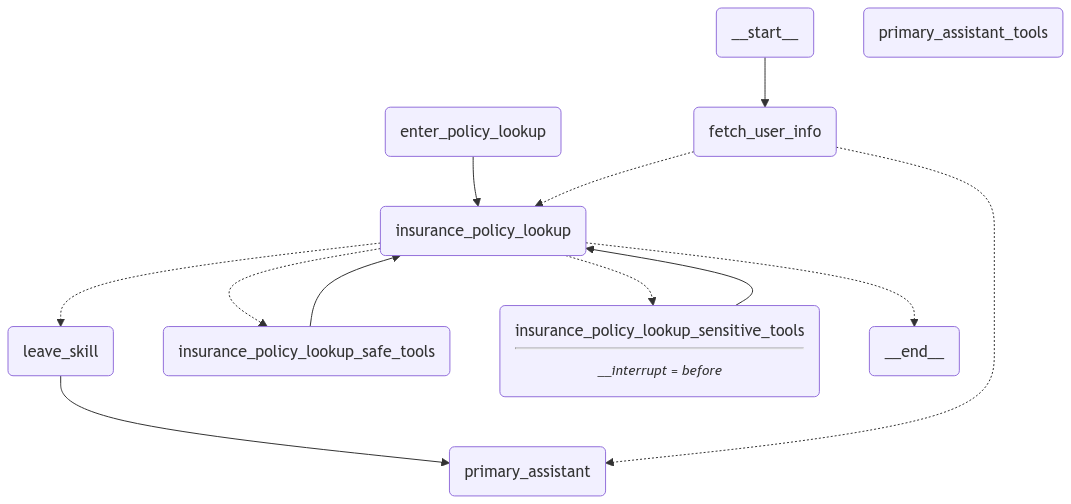

In [99]:
from IPython.display import Image, display

try:
    display(Image(part_4_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [101]:
import shutil
import uuid

# Update with the backup file so we can restart from the original place in each section
# db = update_dates(db)
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "customer_id": "C1001",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

_printed = set()
# We can reuse the tutorial questions from part 1 to see how it does.
for question in tutorial_questions:
    events = part_4_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)
    snapshot = part_4_graph.get_state(config)
    while snapshot.next:
        # We have an interrupt! The agent is trying to use a tool, and the user can approve or deny it
        # Note: This code is all outside of your graph. Typically, you would stream the output to a UI.
        # Then, you would have the frontend trigger a new run via an API call when the user has provided input.
        try:
            user_input = input(
                "Do you approve of the above actions? Type 'y' to continue;"
                " otherwise, explain your requested changed.\n\n"
            )
        except:
            user_input = "y"
        if user_input.strip() == "y":
            # Just continue
            result = part_4_graph.invoke(
                None,
                config,
            )
        else:
            # Satisfy the tool invocation by
            # providing instructions on the requested changes / change of mind
            result = part_4_graph.invoke(
                {
                    "messages": [
                        ToolMessage(
                            tool_call_id=event["messages"][-1].tool_calls[0]["id"],
                            content=f"API call denied by user. Reasoning: '{user_input}'. Continue assisting, accounting for the user's input.",
                        )
                    ]
                },
                config,
            )
        snapshot = part_4_graph.get_state(config)

================================ Human Message =================================

Hi there, I am travelling to Malasiya, Does my insurance cover medical expense?

ℹ️ LOGS : fetch_user_insurance_information called
🎯 ACTION: fetch_user_insurance_information
📝 RESULT: {'CustomerID': 'C1001', 'Name': 'John Smith', 'Age': 53, 'Income': 69116, 'Occupation': 'Nurse', 'MaritalStatus': 'Divorced', 'Children': 0, 'Location': 'Suburban', 'PolicyID': 'P1A', 'PolicyType': 'Auto', 'CoverageAmount': 507042, 'PremiumAmount': 3132, 'RenewalDate': '1/21/2025', 'ClaimID': 'C1A', 'ClaimType': 'Natural Disaster', 'ClaimAmount': 27612, 'ClaimStatus': 'Approved', 'InteractionID': 'I1A', 'InteractionType': 'Call', 'InteractionDate': '11/13/2024', 'InteractionNotes': 'Interaction notes for customer 1', 'Preferences': 'Budget-Friendly', 'BehavioralPatterns': 'Customer 1 prefers online transactions.', 'RiskLevel': 'High', 'RiskFactors': 'Customer 1 has a moderate risk profile due to driving history.', 'Fraudulen

BadRequestError: Error code: 400 - {'error': {'message': "An assistant message with 'tool_calls' must be followed by tool messages responding to each 'tool_call_id'. The following tool_call_ids did not have response messages: call_jaiPKzaxT2LE3omuXDsOBnk1", 'type': 'invalid_request_error', 'param': 'messages.[3].role', 'code': None}}